In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

import random

In [2]:
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator

In [3]:
for dirName,_,fileNames in os.walk('Waste/'):
    for files in fileNames:
        print(os.path.join(dirName,files))

Waste/biological\biological1.jpg
Waste/biological\biological10.jpg
Waste/biological\biological100.jpg
Waste/biological\biological101.jpg
Waste/biological\biological102.jpg
Waste/biological\biological103.jpg
Waste/biological\biological104.jpg
Waste/biological\biological105.jpg
Waste/biological\biological106.jpg
Waste/biological\biological107.jpg
Waste/biological\biological108.jpg
Waste/biological\biological109.jpg
Waste/biological\biological11.jpg
Waste/biological\biological110.jpg
Waste/biological\biological111.jpg
Waste/biological\biological112.jpg
Waste/biological\biological113.jpg
Waste/biological\biological114.jpg
Waste/biological\biological115.jpg
Waste/biological\biological116.jpg
Waste/biological\biological117.jpg
Waste/biological\biological118.jpg
Waste/biological\biological119.jpg
Waste/biological\biological12.jpg
Waste/biological\biological120.jpg
Waste/biological\biological121.jpg
Waste/biological\biological122.jpg
Waste/biological\biological123.jpg
Waste/biological\biologic

In [4]:
def show_image(dir):
    plt.figure(figsize=(12,7))
    for i in range(10):
        plt.subplot(2,5,i+1)
        img = random.choice(os.listdir(dir))
        img = load_img(os.path.join(dir,img))
        plt.subplots_adjust(hspace=0.2)
        x =dir.split("/")[-1]
        if x == "biological":
            plt.suptitle("Biological Images",fontsize=15)
        elif x == "cardboard":
            plt.suptitle("Cardboard Images",fontsize=15)
        elif x == "glass":
            plt.suptitle("Glass Images",fontsize=15)
        elif x == "metal":
            plt.suptitle("metal Images",fontsize=15)
        elif x == "paper":
            plt.suptitle("paper Images",fontsize=15)  
        elif x == "plastic":
            plt.suptitle("Plastic Images",fontsize=15)
        elif x == "trash":
            plt.suptitle("Trash Images",fontsize=15)
        plt.imshow(img)
        
        
    plt.tight_layout()

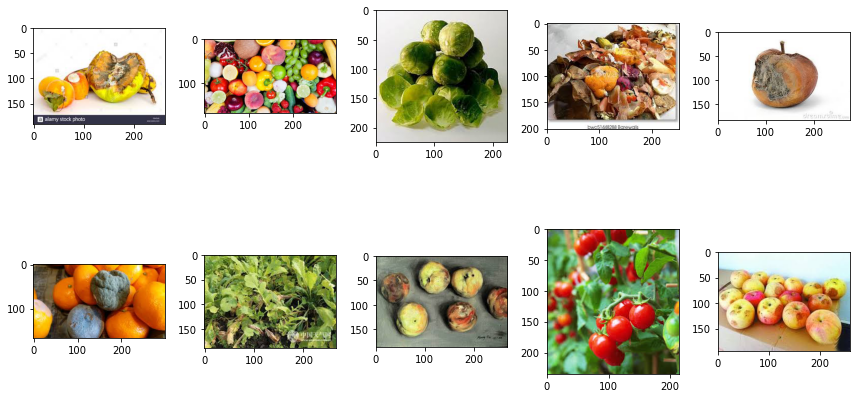

In [5]:
show_image('Waste/biological/')

In [6]:
traindir='Waste/'
os.listdir(traindir)

['biological', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [7]:
ht = 150
wd = 150
train_datagen =  ImageDataGenerator(rescale = 1/255.0,
                                    rotation_range=45,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    validation_split=0.2,
                                    horizontal_flip=True)

train_data = train_datagen.flow_from_directory(directory = traindir,
                                               target_size=(ht,wd),
                                               class_mode = "categorical",
                                               batch_size=32,
                                               subset="training")

val_datagen = ImageDataGenerator(rescale = 1/255.0)

val_data = train_datagen.flow_from_directory(directory = traindir,
                                             target_size=(ht,wd),
                                             class_mode = "categorical",
                                             batch_size=32,
                                             subset="validation")

Found 2812 images belonging to 7 classes.
Found 700 images belonging to 7 classes.


In [8]:
print(train_data.class_indices)

{'biological': 0, 'cardboard': 1, 'glass': 2, 'metal': 3, 'paper': 4, 'plastic': 5, 'trash': 6}


In [9]:
labels='\n'.join(sorted(train_data.class_indices.keys()))

with open('waste_labels.txt','w') as f:
    f.write(labels)

In [10]:

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [11]:
mobileNet=MobileNetV2(weights="imagenet",include_top=False,input_shape=(ht,wd,3))

In [12]:
for l in mobileNet.layers:
    l.trainable=False

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten,Dense,Dropout,Conv2D,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [14]:
model=Sequential()
model.add(mobileNet)
model.add(Conv2D(32,3,activation='relu'))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())
model.add(Dense(7,activation="softmax"))

model.compile(optimizer=Adam(lr=0.001),loss="categorical_crossentropy",metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 3, 3, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 7)                 231       
Total params: 2,626,887
Trainable params: 368,903
Non-trainable params: 2,257,984
_________________________________________________________________


In [17]:
checkpoint = ModelCheckpoint("WasteClassifier.h5",monitor = "val_accuracy",save_best_only = True,verbose=1)
earlystop = EarlyStopping(monitor='val_accuracy',patience=10,verbose=1)

In [18]:
batch_size = 4
history = model.fit_generator(train_data,
                              steps_per_epoch = len(train_data)// batch_size,
                              epochs=30,
                              validation_data = val_data,
                              validation_steps = len(val_data)//batch_size,
                              callbacks = [checkpoint,earlystop],
                              verbose=1)

Epoch 1/30
22/22 [==============================] - ETA: 0s - loss: 0.5203 - accuracy: 0.8457
Epoch 00001: val_accuracy improved from -inf to 0.70625, saving model to WasteClassifier.h5
22/22 [==============================] - 7s 298ms/step - loss: 0.5203 - accuracy: 0.8457 - val_loss: 0.7683 - val_accuracy: 0.7063
Epoch 2/30
22/22 [==============================] - ETA: 0s - loss: 0.5176 - accuracy: 0.8210
Epoch 00002: val_accuracy improved from 0.70625 to 0.75000, saving model to WasteClassifier.h5
22/22 [==============================] - 6s 292ms/step - loss: 0.5176 - accuracy: 0.8210 - val_loss: 0.7556 - val_accuracy: 0.7500
Epoch 3/30
22/22 [==============================] - ETA: 0s - loss: 0.4837 - accuracy: 0.8281
Epoch 00003: val_accuracy improved from 0.75000 to 0.75625, saving model to WasteClassifier.h5
22/22 [==============================] - 7s 310ms/step - loss: 0.4837 - accuracy: 0.8281 - val_loss: 0.7427 - val_accuracy: 0.7563
Epoch 4/30
22/22 [=========================

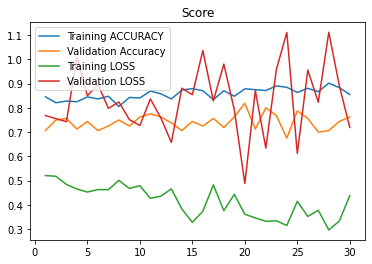

In [19]:
ACC=history.history['accuracy']
LOSS=history.history['loss']
val_ACC=history.history['val_accuracy']
val_LOSS=history.history['val_loss']
epochs=range(1,len(ACC)+1)


plt.title("Score")
plt.plot(epochs,ACC,label='Training ACCURACY')
plt.plot(epochs,val_ACC,label='Validation Accuracy')
plt.legend()

plt.plot(epochs,LOSS,label='Training LOSS')
plt.plot(epochs,val_LOSS,label='Validation LOSS')
plt.legend()

In [20]:
from tensorflow.keras.preprocessing import image

In [21]:
def classifyImg(img):
    label = {0:"daisy",1:"dandelion",2:"rose",3:"sunflower",4:"tulip"} 
    image =cv2.imread(img)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    face=image
    face = cv2.resize(face,(150,150))
    img_scaled = face/255.0
    reshape = np.reshape(img_scaled,(1,150,150,3))
    img = np.vstack([reshape])
    result = model.predict_classes(img)
    
    
    if result == 0: 
        print("Prediction : biological")
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        
        
    elif result == 1:
        print("Prediction : cardboard")
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        
    elif result == 2:
        print("Prediction : glass")
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        
    elif result == 3:
        print("Prediction : metal")
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        
    elif result == 4:
        print("Prediction : paper")
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.imshow(image)
    elif result == 5:
        print("Prediction : plastic")
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.imshow(image)
    elif result == 6:
        print("Prediction : trash")
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.imshow(image)

   
    
plt.show()

Prediction : biological


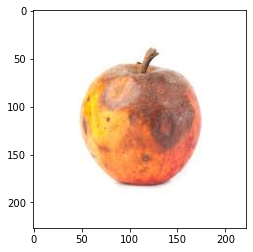

In [80]:
classifyImg('test/3.jfif')

Prediction : biological


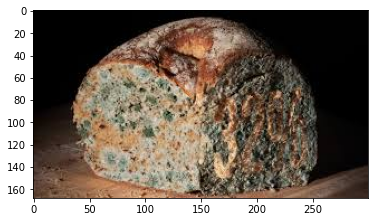

In [98]:
classifyImg('test/52.jpg')

Prediction : plastic


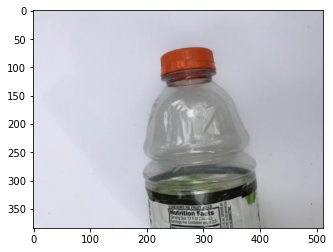

In [82]:
classifyImg('test/30.jpg')

Prediction : glass


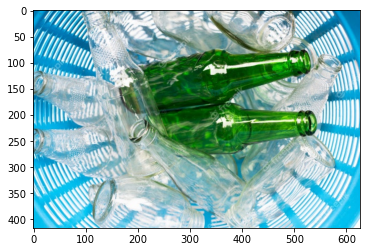

In [84]:
classifyImg('test/11.jpg')

Prediction : metal


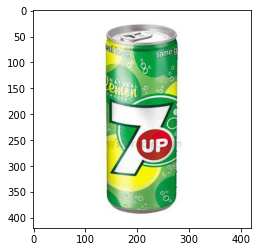

In [86]:
classifyImg('test/20.jpg')

Prediction : paper


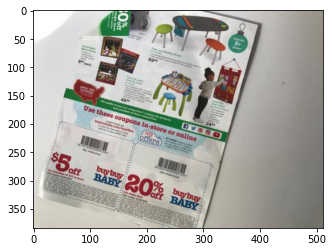

In [87]:
classifyImg('test/28.jpg')

Prediction : paper


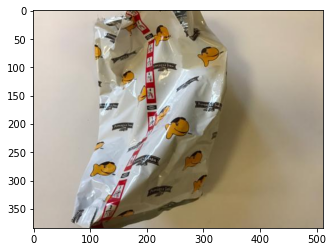

In [88]:
classifyImg('test/41.jpg')

Prediction : biological


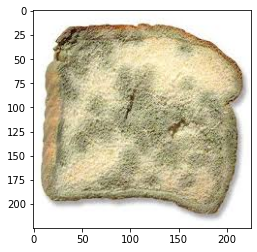

In [109]:
classifyImg('test/53.jpg')

Prediction : glass


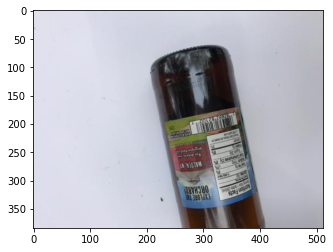

In [90]:
classifyImg('test/62.jpg')

Prediction : cardboard


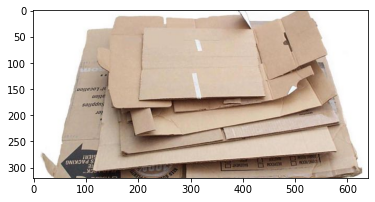

In [92]:
classifyImg('test/8.jpg')

Prediction : cardboard


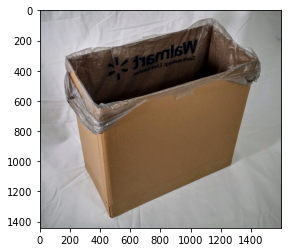

In [93]:
classifyImg('test/9.jpg')

Prediction : metal


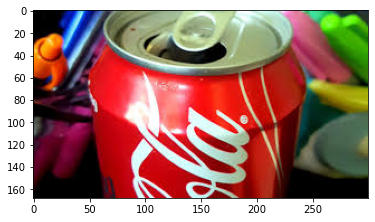

In [94]:
classifyImg('test/17.jfif')

Prediction : metal


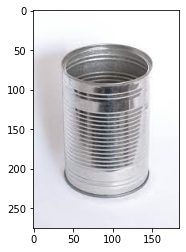

In [95]:
classifyImg('test/16.jfif')

Prediction : cardboard


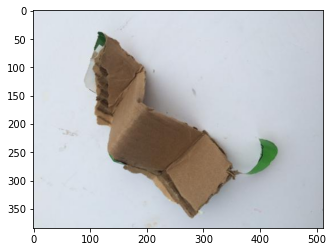

In [100]:
classifyImg('test/73.jpg')

Prediction : paper


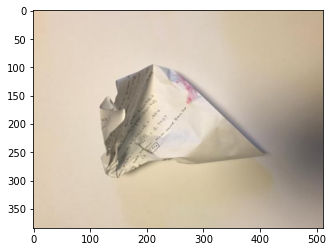

In [101]:
classifyImg('test/29.jpg')

Prediction : paper


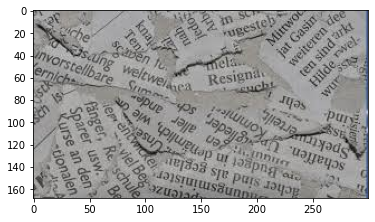

In [103]:
classifyImg('test/26.jfif')

Prediction : metal


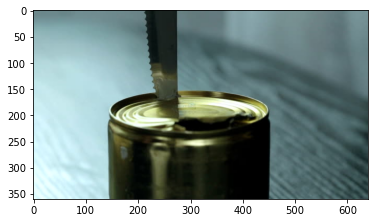

In [107]:
classifyImg('test/23.jpg')

In [111]:
import tensorflow as tf

model = tf.keras.models.load_model('WasteClassifier.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("WasteClassifier_TFL.tflite", "wb").write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmpu02tvw4o\assets


10344756